In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def extract_features(frame1, frame2):
    orb = cv2.ORB_create(nfeatures = 2000)
    
    kp1, des1 = orb.detectAndCompute(frame1, None)
    kp2, des2 = orb.detectAndCompute(frame2, None)
    
    return kp1, kp2, des1, des2

In [3]:
def match_features(kp1, kp2, des1, des2):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    
    img1_pts = []
    img2_pts = []

    for match in matches:
        img1_pts.append(kp1[match.queryIdx].pt)
        img2_pts.append(kp2[match.trainIdx].pt)
        
    img1_pts = np.array(img1_pts, dtype=np.float32)
    img2_pts = np.array(img2_pts, dtype=np.float32)
    
    return matches, img1_pts, img2_pts

In [4]:
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

In [5]:
def constructHomogeneousPose(R, t):
    return np.concatenate((np.concatenate((R,t),axis=1),np.array([[0,0,0,1]])),axis=0)

In [6]:
img1 = load_image('./img1.png')
img2 = load_image('./img2.png')
K = np.array([[551.7050819120993, 0.0, 284.0215789988593],
               [0.0, 551.5259346746498, 186.04513199963452],
               [0.0, 0.0, 1.0]])

In [7]:
kp1, kp2, des1, des2 = extract_features(img1, img2)
matches, img1_pts, img2_pts = match_features(kp1, kp2, des1, des2)

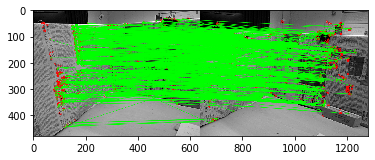

In [8]:
draw_params = dict(matchColor = (0,255,0), singlePointColor=(255,0,0), flags = cv2.DrawMatchesFlags_DEFAULT)
img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, **draw_params)

plt.imshow(img3)

In [10]:
E, mask = cv2.findEssentialMat(img1_pts, img2_pts, K, method=cv2.RANSAC,threshold=1)
mask = mask[:,0]

In [11]:
pts1 = []
pts2 = []
for idx, pt in enumerate(img1_pts):
    if(mask[idx]):
        pts1.append(img1_pts[idx,:])
        pts2.append(img2_pts[idx,:])

pts1 = np.array(pts1)
pts2 = np.array(pts2)

In [12]:
_, R, t, _ = cv2.recoverPose(E, pts1, pts2, K)
T = constructHomogeneousPose(R,t)

In [13]:
P1 = np.concatenate((K,np.array([[0],[0],[0]])),axis=1)
P2 = K @ T[:-1,]

In [14]:
pts = cv2.triangulatePoints(P1, P2, pts1.transpose(), pts2.transpose())
pts = pts/pts[-1,:]

<IPython.core.display.Javascript object>


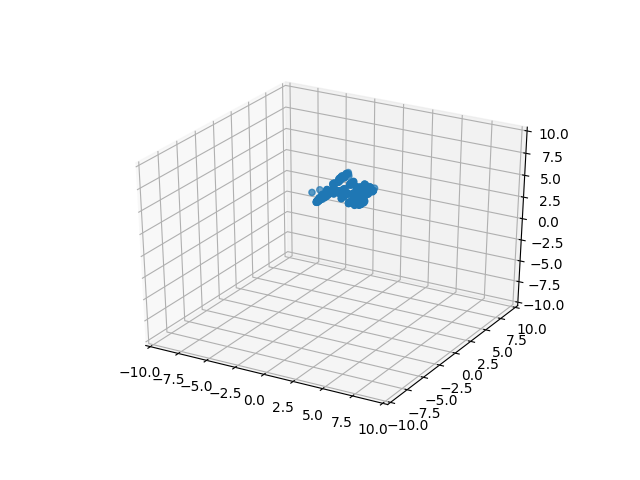

In [15]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(-10,10)
ax.set_ylim3d(-10,10)
ax.set_zlim3d(-10,10)
ax.scatter(pts[0,:],pts[1,:],pts[2,:])